# **Install PyTorch XLA**

For using TPU

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  33006      0 --:--:-- --:--:-- --:--:-- 33006
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
Done updating TPU runtime
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...
\ [1 files][130.2 MiB/130.2 MiB]                                                
Operation completed over 1 objects/130.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...
\ [1 files][138.3 MiB/138.3 MiB]                                                
Operation complet

In [2]:
import torch_xla.core.xla_model as xm

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import transforms
import os
import glob
from PIL import Image
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [4]:
print(torch.__version__)

1.9.0a0+gitc0ac0fe


In [5]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    
])


    

# Prepare Data-Set

In [8]:
data_root = "../input/flickrfaceshq-dataset-ffhq"

class FaceData(torch.utils.data.Dataset):
    def __init__(self, transformations=None, root = '../input/flickrfaceshq-dataset-ffhq'):
        self.root = root
        self.transformations = transformations
        self.img_list = glob.glob(os.path.join(root,'*'))
        self.img_list.sort()
    
    def __len__(self):
        return len(glob.glob("../input/flickrfaceshq-dataset-ffhq/*"))
    
    def mask(self, img):
        canvas = np.full((224,224,3), 255, np.uint8) #draw white canvas
        
        for _ in range(np.random.randint(1,10)):
            x1, x2 = np.random.randint(1,224), np.random.randint(1,224)
            y1, y2 = np.random.randint(1,224), np.random.randint(1,224)
            t = np.random.randint(1,3)
            
            cv2.line(canvas,(x1,y1),(x2,y2),(0,0,0),t)
            
            
        masked_img = img.copy()
        masked_img[canvas==0] = 255
            
        return masked_img, canvas
        
    def random_blur(self,img):
        blur = np.random.choice(['average','gaussian','median'])
        
        if blur == 'average':
            img = cv2.blur(img,(7,7))

        elif blur == 'gaussian':
            img = cv2.GaussianBlur(img,(9,9),0)

        else:
            img = cv2.medianBlur(img,7)

        return img

        
    def __getitem__(self, idx):
     
        y_img = cv2.imread(self.img_list[idx]) #Original image
        y_img = cv2.cvtColor(y_img,cv2.COLOR_BGR2RGB)

        y_pil = Image.fromarray(y_img)
        y = self.transformations(y_pil)
        
        x_img = cv2.imread(self.img_list[idx]) #Image to be transformed        
        x_img = cv2.cvtColor(x_img,cv2.COLOR_BGR2RGB)
        x_img = cv2.resize(x_img,(224,224))
       
        x_img = self.random_blur(x_img)
        
        x,_ = self.mask(x_img)
        x = Image.fromarray(x)
        x = self.transformations(x)
        x = random_noise(x, mode='s&p') #random_noise converts img to float in range[0,1]

        return x, y
        

In [9]:
#GET SAMPLE DATA
data_set = FaceData(transformations=transformations)

sample_loader = torch.utils.data.DataLoader(data_set, batch_size=32)

batch=next(iter(sample_loader))
xx,yy=batch


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:136: UserWarning: Legacy tensor constructor is deprecated. Use: torch.tensor(...) for creating tensors from tensor-like objects; or torch.empty(...) for creating an uninitialized tensor with specific sizes. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_new.cpp:476.)
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


# **Visualize Training Data**

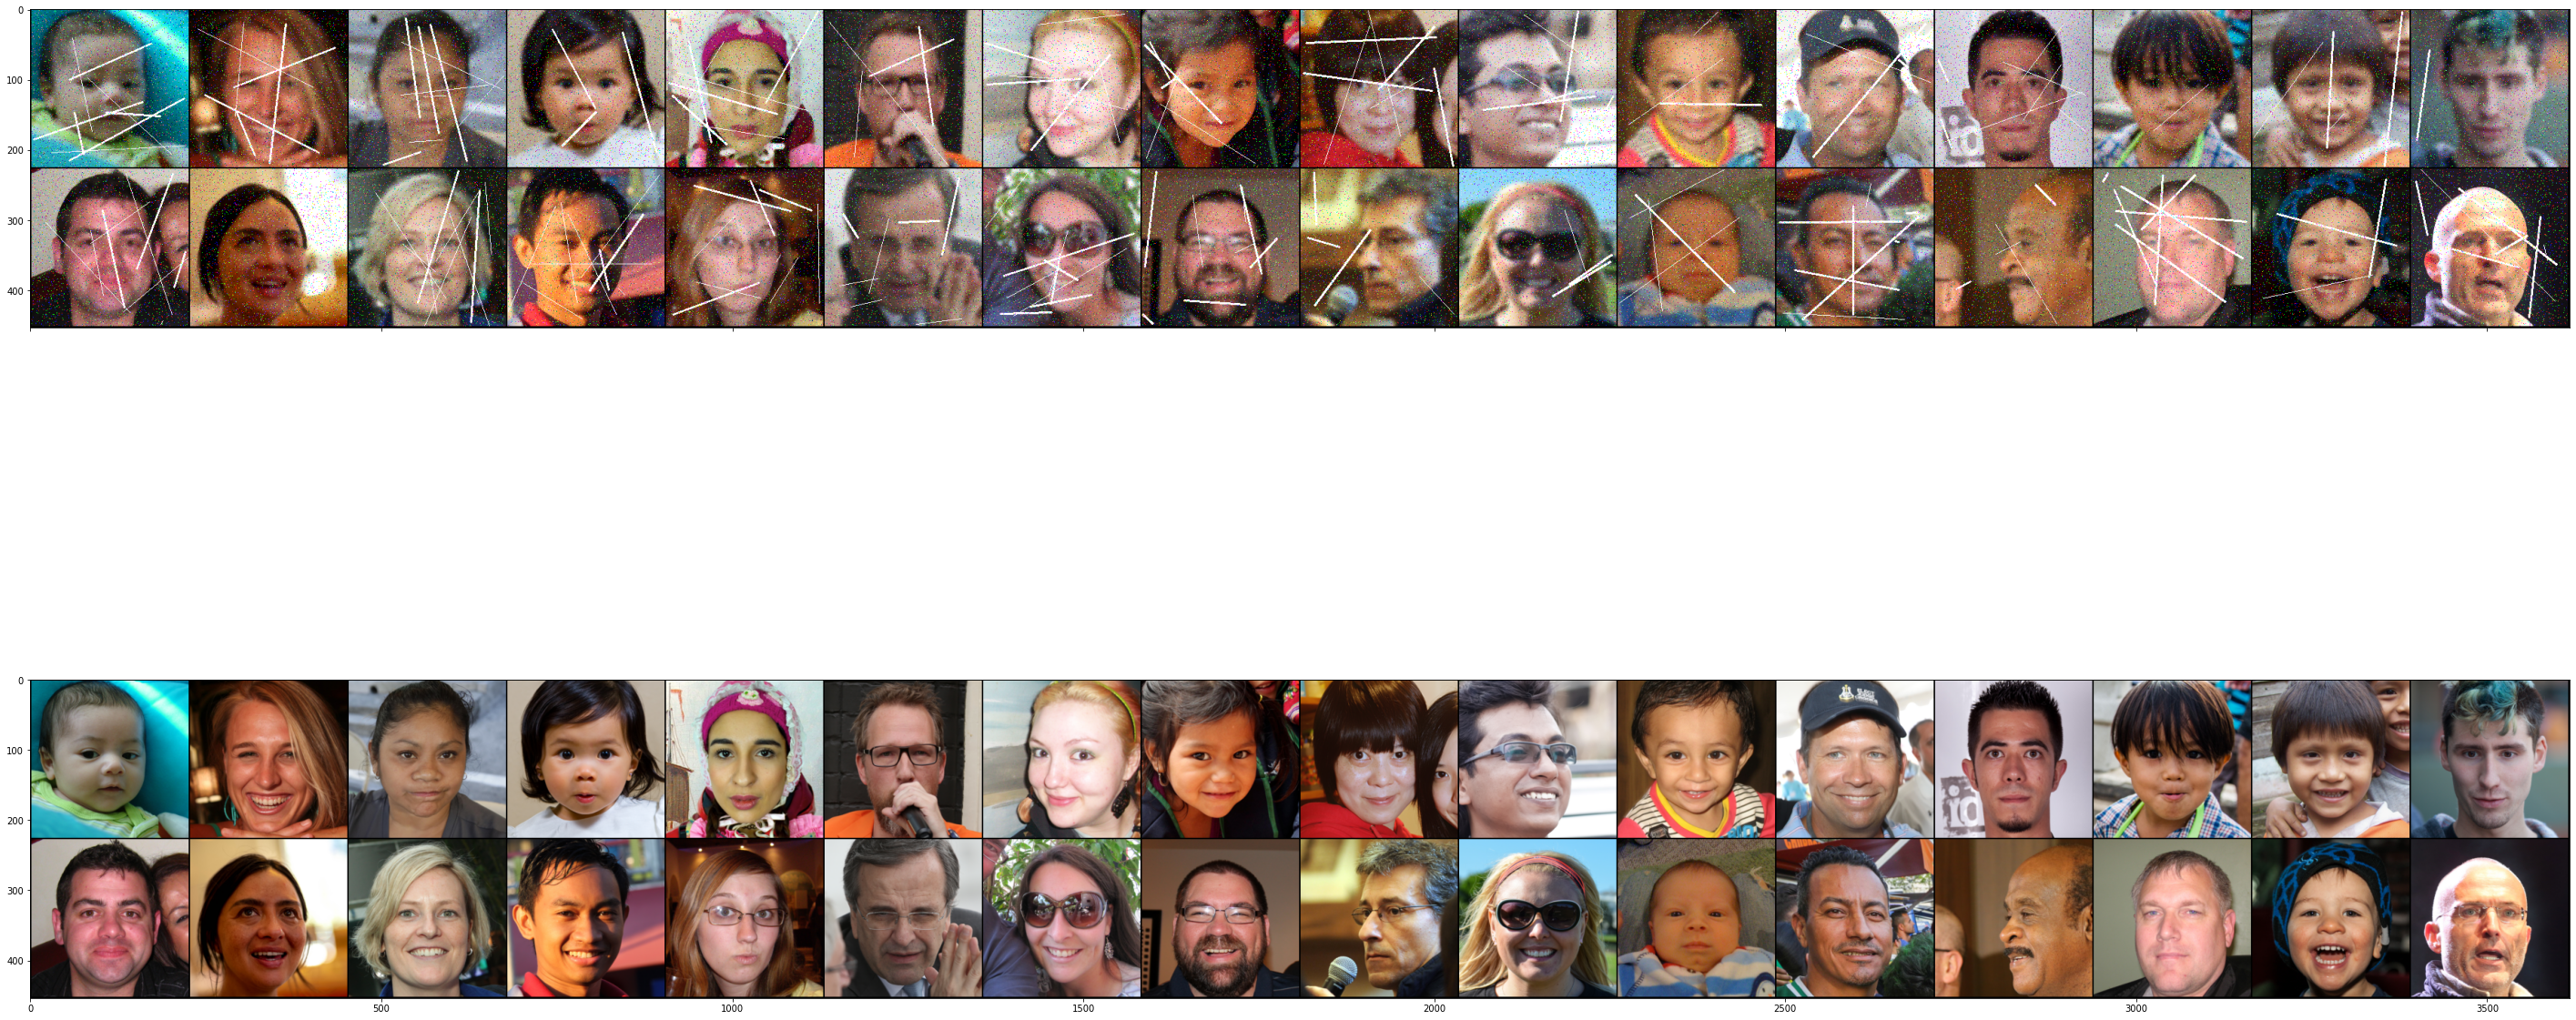

In [10]:
grid1 = torchvision.utils.make_grid(xx,nrow=16)
grid2 = torchvision.utils.make_grid(yy,nrow=16)

fig, axs = plt.subplots(2,1,figsize=(50,50),sharex=True)#2 rows, 1 column

axs[0].imshow(np.transpose(grid1,(1,2,0)))
axs[1].imshow(np.transpose(grid2,(1,2,0)))

plt.subplots_adjust(top=0.5)

# **Define DataLoaders and Split DATA into Train, Validation and Test**

In [11]:
#Define DataLoaders
indices = list(range(len(data_set.img_list)))
val_split = int(0.9*len(data_set.img_list)) 
test_split = int(val_split+ ((len(data_set.img_list)-val_split)//2))

train_indices,val_indices,test_indices = indices[:val_split], indices[val_split:test_split],indices[test_split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_data = torch.utils.data.DataLoader(data_set,batch_size =256, sampler=train_sampler,
                                        num_workers = 8, pin_memory=True)
val_data = torch.utils.data.DataLoader(data_set,batch_size = 16, sampler =val_sampler,
                                      num_workers =4, pin_memory=True)
test_data = torch.utils.data.DataLoader(data_set,batch_size = 4, sampler =test_sampler,
                                      num_workers =4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())

Calculate Mean and Variance:

Used to train VQ-VAE

In [ ]:
##To Get Mean and Variance of Data

# num_pixels = len(train_indices)*224*224*3

# sum_total = 0

# for batch in train_data:
#     sum_total += batch[1].flatten().sum()

# mean =  sum_total/num_pixels

# sum_sqr_error=0
# for batch in train_data:
#     sum_sqr_error += ((batch[1].flatten() - mean).pow(2)).sum()
    
# train_variance = sum_sqr_error/num_pixels

# mean, train_variance

In [13]:
device = xm.xla_device()

In [14]:
print(device)

xla:1


In [15]:
x_variance = 0.0838

# **VQ-VAE Code**

In [16]:
#VQ-VAE

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
    
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)
    
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)


class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

# **Building ConVolutional Decoder**

In [17]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return torch.tanh(x) * torch.sigmoid(y)
    
class Inpaint(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,
                gated = True):
        super(Inpaint, self).__init__()
        
        if gated:
            self.gate = GatedActivation()
            self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=num_hiddens*2,#add *2
                                     kernel_size=3, 
                                     stride=1, padding=1)

            self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                                 num_hiddens=num_hiddens,
                                                 num_residual_layers=num_residual_layers,
                                                 num_residual_hiddens=num_residual_hiddens)
        
            self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                    out_channels=num_hiddens, 
                                                    kernel_size=4, 
                                                    stride=2, padding=1)
            self.conv2 = nn.Conv2d(in_channels=num_hiddens//2, 
                                                    out_channels=num_hiddens//2,
                                                    kernel_size=1, 
                                                    stride=1)

            self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                    out_channels=6, 
                                                    kernel_size=4, 
                                                    stride=2, padding=1)
            self.conv3 = nn.Conv2d(in_channels=3, 
                                                    out_channels=3,
                                                    kernel_size=1, 
                                                    stride=1)
        else:
            self.gate = GatedActivation()
            self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=num_hiddens,
                                     kernel_size=3, 
                                     stride=1, padding=1)

            self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                                 num_hiddens=num_hiddens,
                                                 num_residual_layers=num_residual_layers,
                                                 num_residual_hiddens=num_residual_hiddens)
        
            self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                    out_channels=num_hiddens//2, 
                                                    kernel_size=4, 
                                                    stride=2, padding=1)
            self.conv2 = nn.Conv2d(in_channels=num_hiddens//2, 
                                                    out_channels=num_hiddens//2,
                                                    kernel_size=1, 
                                                    stride=1)

            self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                    out_channels=3, 
                                                    kernel_size=4, 
                                                    stride=2, padding=1)
            self.conv3 = nn.Conv2d(in_channels=3, 
                                                    out_channels=3,
                                                    kernel_size=1, 
                                                    stride=1)

    def forward(self, inputs, gated):
        if gated:
            x = self.gate(self._conv_1(inputs))

            x = (self._residual_stack(x))

            x = self.gate(self._conv_trans_1(x))
  
            x = F.relu(self.conv2(x))
            x = self.gate(self._conv_trans_2(x))
        #RElu
        else:
            x = F.relu(self._conv_1(inputs))

            x = (self._residual_stack(x))

            x = F.relu(self._conv_trans_1(x))

            x = F.relu(self.conv2(x))
            x = F.relu(self._conv_trans_2(x))

        return self.conv3(x)
    

class Inpaint_Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0,inpaint = False,
                activation = 'gated'):
        super(Inpaint_Model, self).__init__()
        
        if activation == 'gated':
            self._inpaint = Inpaint(embedding_dim,
                                    num_hiddens, 
                                    num_residual_layers, 
                                    num_residual_hiddens,gated = True)
            self.gated = True
        else:
            self._inpaint = Inpaint(embedding_dim,
                                    num_hiddens, 
                                    num_residual_layers, 
                                    num_residual_hiddens,gated = False)
            self.gated = False

    def forward(self, x):

        x_recon = self._inpaint(x, self.gated)

        return x_recon

# **Initialize Parameters**

In [19]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay)
model = model.to(device)

inpaint_model = Inpaint_Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay)
inpaint_model = inpaint_model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
#Create Directory to store Weights
os.mkdir('./weights')

# **Train VQ-VAE**

In [ ]:
# #Resume Train VQ-VAE
# # chkpt = torch.load("../input/e3241/_epoch_41",map_location= 'cpu')

# # model.load_state_dict(chkpt['model_state_dict'])
# # optimizer.load_state_dict(chkpt['optimizer_state_dict'])
# # chkpt_epoch = chkpt['epoch']
# # loss_recon = chkpt['loss']['recon_error']
# # loss_perplex = chkpt['loss']['perplexity']

##Train VQ-VAE
# model.train()

# train_res_recon_error = loss_recon.copy()
# train_res_perplexity = loss_perplex.copy()

# for i in range(70):#Total=70 epoch

#     for x,_ in train_data:

#         x = x.to(device)                         
#         optimizer.zero_grad()

              
#         vq_loss, data_recon, perplexity = model(x)
#         recon_error = F.mse_loss(data_recon, x) / x_variance 
#         loss = recon_error + vq_loss
#         loss.backward()

#         optimizer.step()
        
#         train_res_recon_error.append(recon_error.item())
#         train_res_perplexity.append(perplexity.item())
        
#         xm.mark_step()

        
#     if (i+1) % 10 == 0:
#         print('%d iterations' % (i+1))
#         print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
#         print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
#         print()

#     if (i+1)%5 == 0:
#         torch.save({'epoch':i,
#                     'model_state_dict':model.state_dict(),
#                     'optimizer_state_dict':optimizer.state_dict(),
#                     'loss':{'recon_error':train_res_recon_error.copy(),'perplexity':train_res_perplexity.copy()},
#                    },os.path.join('./weights',f'_epoch_{i+41}'))

# **Train Decoder**

In [ ]:
#TRAIN DECODER
chkpt = torch.load("../input/656055/_epoch_60",map_location= device)

model.load_state_dict(chkpt['model_state_dict'])
inpaint_optimizer = torch.optim.Adam(inpaint_model.parameters(), lr=learning_rate)

#Resume Train
# chkpt_inpaint = torch.load("../input/inpaint-71/inpaint_epoch_71",map_location= device)
# inpaint_model.load_state_dict(chkpt_inpaint['model_state_dict'])
# inpaint_optimizer.load_state_dict(chkpt_inpaint['optimizer_state_dict'])
# loss_recon = chkpt_inpaint['loss']['recon_error']

# train_res_recon_error = chkpt['loss']['recon_error'].copy()
# train_res_perplexity = chkpt['loss']['perplexity'].copy()
decoder_train_res_recon_error = []#loss_recon.copy()
# decoder_train_res_perplexity = []

#Train DECODER
model.eval()
inpaint_model.train()
for param in model.parameters():
    param.requires_grad = False

# for m in model._inpaint.modules():
#     if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
#         nn.init.normal_(m.weight)
#         if m.bias != None:
#             nn.init.constant_(m.bias, 0)

# for param_d in model._inpaint.parameters():
#     param_d.requires_grad = True


for i in range(35): #Total:75
#     b=0
    for x,y in train_data:
#         (data, y) = next(iter(train_data)) #ADDED 
        x = x.to(device)                          #ADDED LINE
        y = y.to(device)
        
        inpaint_optimizer.zero_grad()
#         print(f'data:{data.shape}')
#         print(f'y:{y.shape}')
              
        x1 = model._pre_vq_conv(model._encoder(x))
        _,z,_,_ = model._vq_vae(x1)
        
        data_recon = inpaint_model(z)
#         print(f'data_recon:{data_recon.shape}')
        recon_loss = F.mse_loss(data_recon, y) #/ y_variance #ORIGINAL: data in-place of y
        
        recon_loss.backward()
#         b+=1
#         print(b)
        inpaint_optimizer.step()
        
        decoder_train_res_recon_error.append(recon_loss.item())
#         decoder_train_res_perplexity.append(perplexity.item())

        xm.mark_step()
    
#     if (i+1) % 10 == 0:
#         print('%d iterations' % (i+1))
#         print('recon_error: %.3f' % np.mean(decoder_train_res_recon_error[-100:]))
#         print('perplexity: %.3f' % np.mean(decoder_train_res_perplexity[-100:]))
#         print()

    if (i+1)%3 == 0:
        torch.save({'epoch':i,
                    'model_state_dict':inpaint_model.state_dict(),
                    'optimizer_state_dict':inpaint_optimizer.state_dict(),
                    'loss':{'recon_error':decoder_train_res_recon_error.copy()},
                   },os.path.join('./weights',f'inpaint_relu_epoch_{i+1}'))


# **Visualize Results**

In [22]:
inpaint_model_gated = Inpaint_Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

inpaint_model_relu = Inpaint_Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay, activation = 'relu').to(device)

In [24]:
chkpt = torch.load("../input/656055/_epoch_60",map_location=torch.device('cpu'))
chkpt_inpaint = torch.load("../input/relu-inpaint-3033/inpaint_relu_epoch_33",map_location=torch.device('cpu'))
model.load_state_dict(chkpt['model_state_dict'])

inpaint_model_relu.load_state_dict(chkpt_inpaint['model_state_dict'])

model.eval()
inpaint_model_relu.eval()

(valid_originals, y) = next(iter(val_data))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = inpaint_model_relu(valid_quantize)

In [28]:
#Check Inpaint Gated Activation
chkpt = torch.load("../input/656055/_epoch_60",map_location=torch.device('cpu'))
chkpt_inpaint = torch.load("../input/inpaint35/inpaint_epoch_35 (1)",map_location=torch.device('cpu'))
model.load_state_dict(chkpt['model_state_dict'])

inpaint_model_gated.load_state_dict(chkpt_inpaint['model_state_dict'])

model.eval()
inpaint_model_gated.eval()

# (valid_originals, y) = next(iter(val_data))
# valid_originals = valid_originals.to(device)

# vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
# _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions_gated = inpaint_model_gated(valid_quantize)


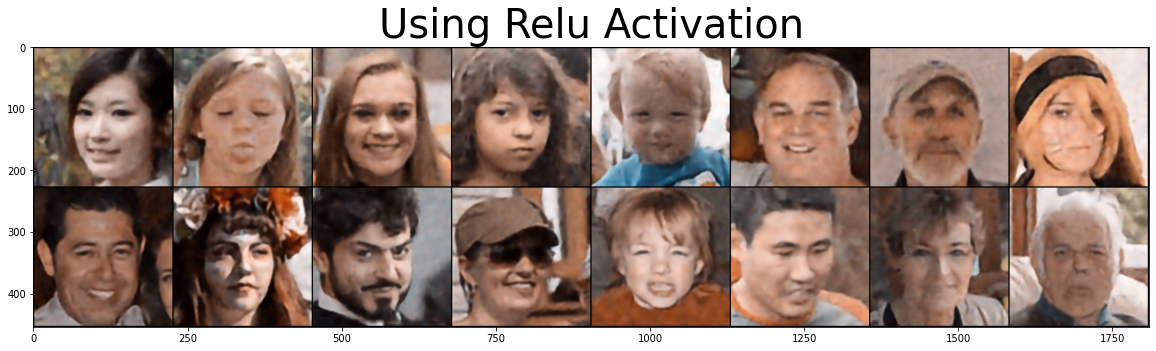

In [29]:
from torchvision.utils import make_grid
def show(img,title):
    npimg = img.numpy()
    _, ax = plt.subplots(figsize=(20,20))
    fig = ax.imshow(np.transpose(npimg, (1,2,0)))
    fig.axes.get_xaxis().set_visible(True)
    fig.axes.get_yaxis().set_visible(True)
    plt.title(title, fontsize=40)
    plt.savefig(f"./{title}")

show(make_grid(valid_reconstructions.cpu().data),"Using Relu Activation" )

In [ ]:
show(make_grid(valid_reconstructions_gated.cpu().data),"Using Gated Activation" )

In [ ]:
show(make_grid(valid_originals.cpu().data),"Input to Model" )

In [ ]:
loss = chkpt_inpaint['loss']['recon_error']
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(1,2,1)
ax.plot(loss)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')